In [1]:
import os
import glob
import itertools
import json
import importlib
import cv2

import matplotlib as mpl
import scipy.stats as spstats
import dill as pkl
import pandas as pd
import numpy as np
import seaborn as sns
import pylab as pl
import statsmodels.api as sm
import tifffile as tf

In [2]:
import sys
sys.path.append("..")

In [3]:
from utils import plotting as pplot

In [3]:
from utils import plotting as pplot
from utils import rf_utils as rfutils
from utils import gratings_utils as gutils
from utils import roi_utils as roiutils
from utils import retino_utils as retutils
from utils import aggregate_datasets as aggr
from utils import helpers as hutils

In [36]:
%matplotlib notebook

In [5]:
import allensdk as ak

# Source

In [7]:
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
rootdir='/n/coxfs01/2p-data'

traceid = 'traces001'
response_type='dff'
responsive_test='nstds'
responsive_thr=0.05 if responsive_test=='ROC' else 10.0
n_stds=2.5
n_bootstrap_iters=1000
n_resamples=20

print(responsive_test, responsive_thr)

nstds 10.0


In [8]:
ori_fit_desc = gutils.get_fit_desc(response_type=response_type, 
                            responsive_test=responsive_test, 
                            n_stds=n_stds, responsive_thr=responsive_thr, 
                            n_bootstrap_iters=n_bootstrap_iters, 
                            n_resamples=n_resamples)
data_id = '|'.join([traceid, ori_fit_desc])
print(data_id)

traces001|fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20


# Plotting

In [9]:
#### Plotting params
visual_areas, area_colors = pplot.set_threecolor_palette()
pplot.set_plot_params(labelsize=6, lw_axes=0.25)

# Aggregate meta 

In [10]:
importlib.reload(aggr)

<module 'utils.aggregate_datasets' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/utils/aggregate_datasets.py'>

In [11]:
sdata, cells0 = aggr.get_aggregate_info(visual_areas=visual_areas, return_cells=True)
# cells, missing_seg = aggr.get_cells_by_area(sdata, return_missing=True)
meta = sdata[sdata.experiment.isin(['gratings'])].copy()

all_dkeys = [(va, dk) for (va, dk), g in meta.groupby(['visual_area', 'datakey'])]
CELLS = pd.concat([g for (va, dk), g in cells0.groupby(['visual_area', 'datakey'])\
                                  if (va, dk) in all_dkeys])
CELLS[['visual_area', 'animalid', 'session', 'fovnum']]\
            .drop_duplicates().groupby(['visual_area']).count()

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 3 dsets


,animalid,session,fovnum
visual_area,,,
Li,15,15,15
Lm,11,11,11
V1,9,9,9


# Output dir

In [12]:
dst_dir = os.path.join(aggregate_dir, 'gratings-tuning', 
                       '%s-%s' % (traceid, ori_fit_desc))
print(dst_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20


# All fits

In [13]:
gdata, missing_ = gutils.aggregate_ori_fits(CELLS, traceid=traceid, fit_desc=ori_fit_desc,
                             return_missing=True) 
gdata = hutils.split_datakey(gdata)

gdata['tf'] = gdata['sf']*gdata['speed'] # fit params
gdata.head()

/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/utils/gratings_utils.py:174: RuntimeWarning: invalid value encountered in sqrt
  gfit = np.mean(bootr['results']['r2']) * (1-iqr) * np.sqrt(r2_comb)


,asi,dsi,response_null,response_offset,response_pref,sigma,theta_pref,r2,cell,r2comb,gof,sf,size,speed,visual_area,datakey,animalid,fov,session,tf
0,0.528705,0.524802,0.025275,-0.010931,0.038352,52.129545,0.000000,0.727584,160.0,0.365496,0.376922,0.1,60.0,10.0,Li,20190314_JC070_fov1,JC070,FOV1_zoom2p0x,20190314,1.0
1,0.341041,0.685649,0.020652,-0.017558,0.059309,53.811532,132.244898,0.793545,170.0,0.323455,0.397306,0.1,60.0,10.0,Li,20190314_JC070_fov1,JC070,FOV1_zoom2p0x,20190314,1.0
2,0.590751,0.679958,0.009313,-0.001160,0.027233,39.562740,352.653061,0.892822,172.0,0.899031,0.765403,0.1,60.0,10.0,Li,20190314_JC070_fov1,JC070,FOV1_zoom2p0x,20190314,1.0
3,0.241354,0.572965,0.024139,-0.021777,0.047835,69.826945,227.755102,0.671892,177.0,0.660583,0.458513,0.1,60.0,10.0,Li,20190314_JC070_fov1,JC070,FOV1_zoom2p0x,20190314,1.0
4,0.407956,0.362389,0.017694,-0.012919,0.037090,70.338493,80.816327,0.603767,178.0,0.327887,0.230345,0.1,60.0,10.0,Li,20190314_JC070_fov1,JC070,FOV1_zoom2p0x,20190314,1.0


In [14]:
gdata[gdata['r2comb']>=0.5][['visual_area', 'datakey', 'cell']]\
    .drop_duplicates().groupby(['visual_area']).count()

,datakey,cell
visual_area,,
Li,160,160
Lm,422,422
V1,492,492


# All data

In [25]:
importlib.reload(aggr)

<module 'utils.aggregate_datasets' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/utils/aggregate_datasets.py'>

In [26]:
trial_epoch='plushalf'
experiment='gratings'
NDATA = aggr.get_aggregate_data(experiment, traceid=traceid, 
                      response_type=response_type, epoch=trial_epoch,
                      responsive_test=responsive_test, verbose=False,
                      responsive_thr=responsive_thr, n_stds=n_stds)

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 3 dsets
['gratings']
...loading: /n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_gratings_trialmeans_traces001_nstds-thr-10.00_dff_plushalf.pkl


#### Filter fits

In [27]:
best_gof_ixs = gdata.groupby(['visual_area', 'datakey', 'cell'])['gof']\
                .transform(max) == gdata['gof']
assert gdata.loc[best_gof_ixs].groupby(['visual_area', 'datakey', 'cell'])\
        .count().max().max()==1
bestg = gdata.loc[best_gof_ixs].copy()
bestg.groupby(['visual_area']).count()

# old_rats = ['JC061', 'JC067', 'JC070', 'JC073']
# bestg = p3.split_datakey(bestg)
# bestg = bestg[~bestg.animalid.isin(old_rats)]
# bestg[bestg.visual_area=='Li']['datakey']

,asi,dsi,response_null,response_offset,response_pref,sigma,theta_pref,r2,cell,r2comb,gof,sf,size,speed,datakey,animalid,fov,session,tf
visual_area,,,,,,,,,,,,,,,,,,,
Li,261,261,261,261,261,261,261,261,261,261,261,261,261,261,261,261,261,261,261
Lm,619,619,619,619,619,619,619,619,619,619,619,619,619,619,619,619,619,619,619
V1,686,686,686,686,686,686,686,686,686,686,686,686,686,686,686,686,686,686,686


In [28]:
# Assign "preferred theta" for tested values
theta_vals = np.linspace(0, 360, 9)
print(theta_vals)
bestg['tested_theta'] = [theta_vals[np.where(np.abs(t-theta_vals)== np.min(np.abs(t-theta_vals)))[0][0]] % 360. \
                            for t in bestg['theta_pref'].values]
bestg['tested_theta'] = bestg['tested_theta'].astype(float)

[  0.  45.  90. 135. 180. 225. 270. 315. 360.]


<IPython.core.display.Javascript object>


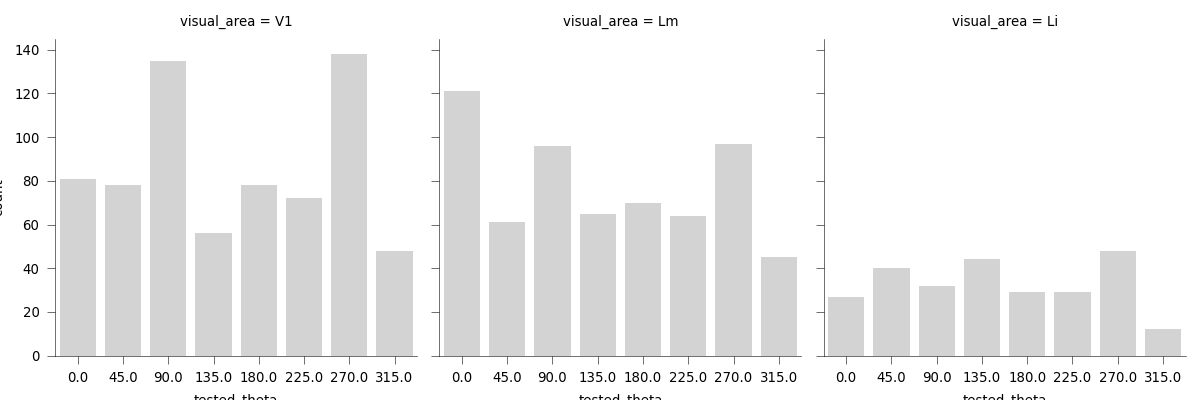

In [42]:
sns.catplot(x='tested_theta', col='visual_area', data=bestg, kind='count',
            height=2.5, col_order=visual_areas, color='lightgrey')
# bestg.groupby(['visual_area', 'tested_theta'])['cell'].size().plot(kind='bar')

In [43]:
# Drop repeat FOVs based on N fits
fit_thr=0.50
counts = bestg[bestg['gof']>=fit_thr][['visual_area', 'datakey', 'cell']]\
                    .drop_duplicates()\
                    .groupby(['visual_area', 'datakey']).count().reset_index()
u_dkeys = aggr.drop_repeats(counts)
NDATA1 = pd.concat([g for (va, dk), g in NDATA.groupby(['visual_area', 'datakey'])\
          if (va, dk) in u_dkeys])
NDATA[['visual_area', 'datakey', 'cell']].drop_duplicates()\
    .groupby(['visual_area']).count()

,datakey,cell
visual_area,,
Li,316,316
Lm,734,734
V1,825,825


<IPython.core.display.Javascript object>


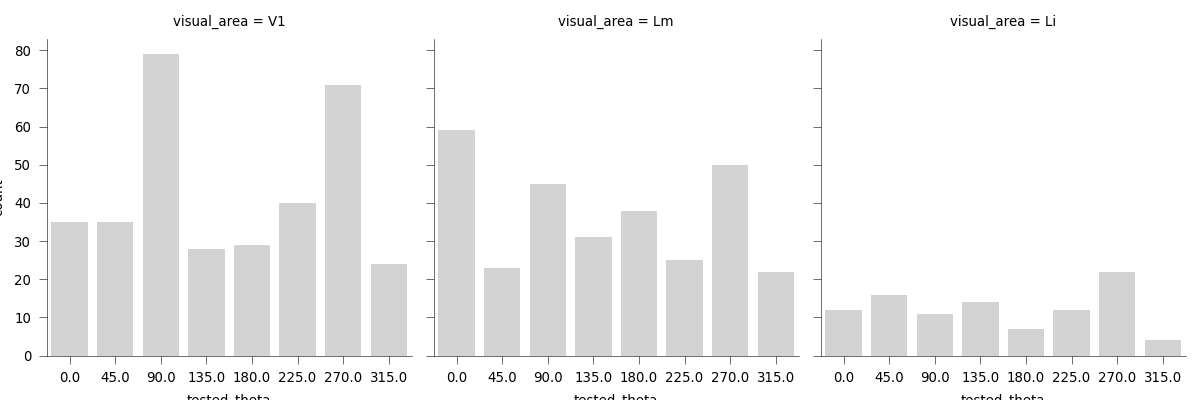

In [45]:
gof_thr=0.5
passg = bestg[bestg['gof']>=gof_thr].copy()
sns.catplot(x='tested_theta', col='visual_area', data=passg, kind='count',
            height=2.5, col_order=visual_areas, color='lightgrey')

# Aggregate metrics

In [26]:
%matplotlib notebook

In [46]:
#### Set current output dir
curr_dst_dir = os.path.join(dst_dir, 'aggregate_metrics')
if not os.path.exists(curr_dst_dir):
    os.makedirs(curr_dst_dir)
print(curr_dst_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20/aggregate_metrics


### Signal corrs

In [47]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [287]:
# def calculate_signal_correlations(tuning_):
#     '''
#     tuning_ (pd.DataFrame): nconds x nrois -- unstack NDATA for easy column-wise ops.
#     Each entry is the mean response (across trials) for a given stim condition.
#     481 ms ± 5.54 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
#     '''
#     # Calculate signal corrs
#     corrs_ = {}
#     rois_ = [i for i in tuning_.columns if hutils.isnumber(i)]
#     # Get unique pairs, then iterate thru and calculate pearson's CC
#     for col_a, col_b in itertools.combinations(rois_, 2):
#         corrs_['%i_%i' % (col_a, col_b)] = spstats.pearsonr(tuning_[col_a], 
#                                                              tuning_[col_b])
#     signal_corrs = pd.DataFrame.from_dict(corrs_, orient='index')
#     signal_corrs.columns = ['p_cc', 'p_value']
#     signal_corrs['cell_1'] = [int(r.split('_')[0]) for r in signal_corrs.index]
#     signal_corrs['cell_2'] = [int(r.split('_')[1]) for r in signal_corrs.index]
#     signal_corrs['neuron_pair'] = signal_corrs.index

#     return signal_corrs

# def calculate_noise_correlations(zscored_):
#     '''
#     tuning_ (pd.DataFrame): nconds x nrois -- unstack NDATA for easy column-wise ops.
#     Each entry is the mean response (across trials) for a given stim condition.
#     '''
#     # Calculate noise corrs: Pearson correlation of the single-trial 
#     # stimulus responses for a pair of neurons & a given stimulus.
#     # Then, average over stimuli later.
#     corrs_ = {}
#     rois_ = [i for i in zscored.columns if hutils.isnumber(i)]
#     # Get unique pairs, then iterate thru and calculate pearson's CC
#     for cfg, g in zscored.groupby(['config']):
#         for col_a, col_b in itertools.combinations(rois_, 2):
#             r, p = spstats.pearsonr(g[col_a], g[col_b])
#             corrs_['%i_%i_%s' % (col_a, col_b, cfg)]  = (r, p, cfg)
#     noise_corrs = pd.DataFrame.from_dict(corrs_, orient='index')
#     noise_corrs.columns = ['p_cc', 'p_value', 'config']
#     noise_corrs['cell_1'] = [int(r.split('_')[0]) for r in noise_corrs.index]
#     noise_corrs['cell_2'] = [int(r.split('_')[1]) for r in noise_corrs.index]
#     noise_corrs['config'] = [r.split('_')[2] for r in noise_corrs.index]
#     noise_corrs['neuron_pair'] = [(r.split('_config')[0]) for r in noise_corrs.index]
    
#     return noise_corrs

def calculate_corrs(ndf, curr_cells=None, curr_cfgs=None):
    if curr_cells is None: 
        curr_cells = ndf['cell'].unique()
    if curr_cfgs is None:
        curr_cfgs = ndf['config'].unique()
    ndf1 = ndf[(ndf.config.isin(curr_cfgs)) & (ndf['cell'].isin(curr_cells))].copy()
    # Reshape dataframe to ntrials x nrois
    trial_means0 = aggr.stacked_neuraldf_to_unstacked(ndf1)
    cfgs_by_trial = trial_means0['config']
    # Zscore trials
    zscored = aggr.zscore_dataframe(trial_means0[curr_cells])
    zscored['config'] = cfgs_by_trial
    # Get mean response per condition
    #tuning_ = zscored.groupby(['config']).mean().reset_index()
    # Get signal corrs
    #signal_corrs = calculate_signal_correlations(tuning_)
    signal_corrs = calculate_signal_corrs(zscored)
    # Get Noise correlations
    #noise_corrs0 = calculate_noise_correlations(zscored)
    noise_corrs0 = calculate_noise_corrs(zscored)
    # Average over stimulus conditions 
    noise_corrs = noise_corrs0.groupby(['neuron_pair']).mean().reset_index()
    # Combine
    corrs = pd.merge(signal_corrs, noise_corrs)
    
    return corrs

def calculate_signal_corrs(zscored, included_configs=None):
    ''' Calculate signal correlations.
    Get pairwise CC for condition vectors (each point is a cond, avg across trials).
    
    zscored (pd.DataFrame): 
        Unstacked, zscored NDATA for easy column-wise ops.
        Columns are cells + config, rows are trials
        
    Returns: cc (pd.DataFrame)
        columns: cell_1, cell_2, neuron_pair, and correlation coeff. 
    
    Note: Faster than itertools method.
          8.91 ms ± 285 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
    '''
    if included_configs is None:
        included_configs = zscored['config'].unique()
        
    # Each entry is the mean response (across trials) for a given stim condition.
    # tuning_ : df, nconds x nrois
    zscored.index.name = None
    zscored.columns.name = None
    tuning_ = zscored[zscored['config'].isin(included_configs)]\
                                   .groupby(['config']).mean().reset_index()
    cc = do_pairwise_cc_melt(tuning_, metric_name='signal_cc')
    
    return cc

def calculate_noise_corrs(zscored, method='pearson'):
    ''' Calculate noise correlations.
    For each condition, get pairwise CC for trial vectors (each point is a trial).
    Should average across conditions to get 1 noise CC per neuron pair.
    
    zscored (pd.DataFrame): 
        Unstacked, zscored NDATA for easy column-wise ops.
        Columns are cells + config, rows are trials
        
    Returns: cc (pd.DataFrame)
        columns: cell_1, cell_2, neuron_pair, and correlation coeff. 
    
    Note: Faster than itertools method.
          8.91 ms ± 285 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
    '''
    c_=[]
    for cfg, df_ in zscored.groupby(['config']):
        df_.index.name = None
        df_.columns.name = None
        cc_ = do_pairwise_cc_melt(df_, metric_name='noise_cc', 
                                  include_diagonal=False)
        cc_['config'] = cfg
        c_.append(cc_)
    cc = pd.concat(c_, axis=0)
    return cc

def do_pairwise_cc_melt(df_, metric_name='cc', include_diagonal=False):
    cc = melt_square_matrix(df_.corr(), metric_name=metric_name, 
                            include_diagonal=include_diagonal)
    cc = cc.rename(columns={'row': 'cell_1', 'col': 'cell_2'})
    cc['neuron_pair'] = ['%i_%i' % (c1, c2) for \
                         c1, c2 in cc[['cell_1', 'cell_2']].values]
    return cc
    
def melt_square_matrix(df, metric_name='value', add_values={}, include_diagonal=False):

    k = 0 if include_diagonal else 1
    df = df.where(np.triu(np.ones(df.shape), k=k).astype(np.bool))

    df = df.stack().reset_index()
    df.columns=['row', 'col', metric_name]

    if len(add_values) > 0:
        for k, v in add_values.items():
            df[k] = [v for _ in np.arange(0, df.shape[0])]

    return df



#### Example FOV & CELL

In [115]:
va = 'V1'
dk='20190617_JC097_fov1'
selective_only=False

ndf = NDATA[(NDATA.visual_area==va) & (NDATA.datakey==dk)].copy()
# Select cells
if selective_only:
    curr_cells = passg[(passg.visual_area==va) 
                    & (passg.datakey==dk)]['cell'].unique()
    if len(curr_cells)<5:
        print("Skipping.")
        #continue
else:
    curr_cells = ndf['cell'].unique()
# Select stimuli and trials
sdf = aggr.get_stimuli(dk, experiment='gratings')
curr_cfgs = sdf.index.tolist()
corrs = calculate_corrs(ndf, curr_cells=curr_cells, curr_cfgs=curr_cfgs)


#### Representational Similarity Matrix

<IPython.core.display.Javascript object>


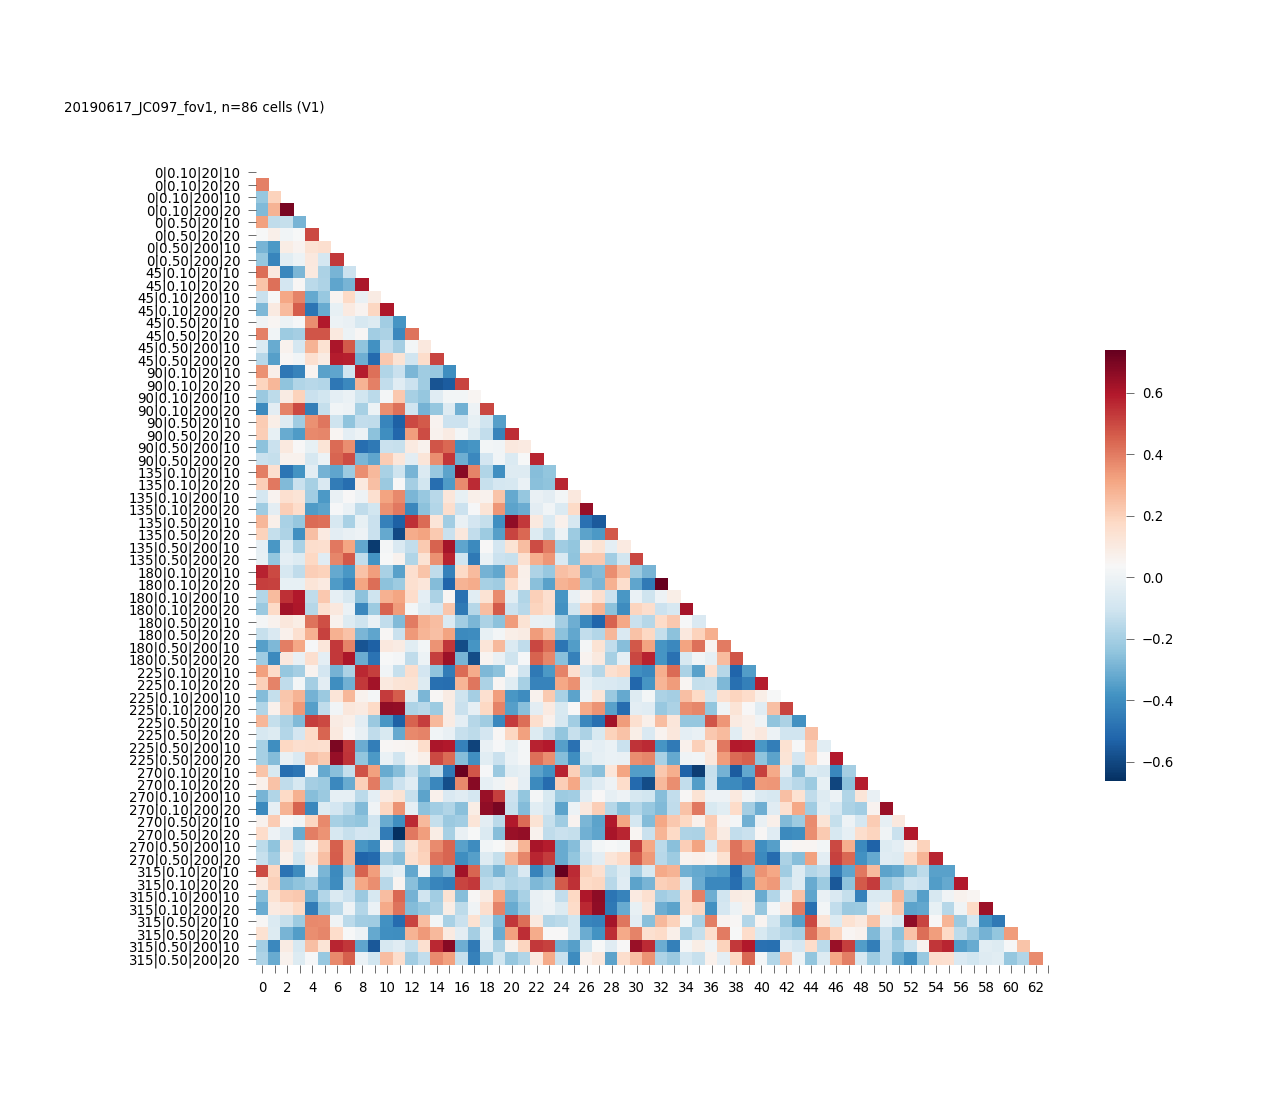

Text(0.05, 0.9, '20190617_JC097_fov1, n=86 cells (V1)')

In [125]:
# Get mean response per condition
tuning_ = zscored.groupby(['config']).mean().reset_index()
rois_ = [i for i in tuning_.columns if hutils.isnumber(i)]
sdf['tf'] = sdf['sf']*sdf['speed']
xlabels = ['%i|%.2f|%i|%i' % (o, sf, sz, sp) for (o, sf, sz, sp) in \
           sdf.loc[tuning_['config']][['ori', 'sf', 'size', 'speed']].values]

rmat = tuning_[rois_].T.corr(method='spearman')
mask = np.triu(np.ones_like(rmat, dtype=bool))

fig, ax = pl.subplots(figsize=(8,7))
sns.heatmap(rmat, mask=mask, cmap='RdBu_r', square=True, cbar_kws={"shrink": 0.5})
ax.set_yticks(np.array(range(64))+0.5)
ax.set_xticks(np.array(range(64))+0.5)
ax.set_yticklabels(xlabels, rotation=0)
#ax.set_aspect('equal')
pl.subplots_adjust(left=0.2, right=0.98)
fig.text(0.05, 0.9, '%s, n=%i cells (%s)' % (dk, len(rois_), va))

#### Distributions of Signal and Noise Correlations

In [126]:
currfits = passg[(passg.visual_area==va) & (passg.datakey==dk)].copy()

sorter=['gof', 'r2comb']
top5 = currfits.sort_values(by=sorter, ascending=False)\
        [['gof', 'r2', 'response_pref', 'tf', 'cell']].iloc[0:5]['cell'].values
bottom5 = currfits.sort_values(by=sorter, ascending=True)\
        [['gof', 'r2', 'response_pref', 'tf', 'cell']].iloc[0:5]['cell'].values

<IPython.core.display.Javascript object>


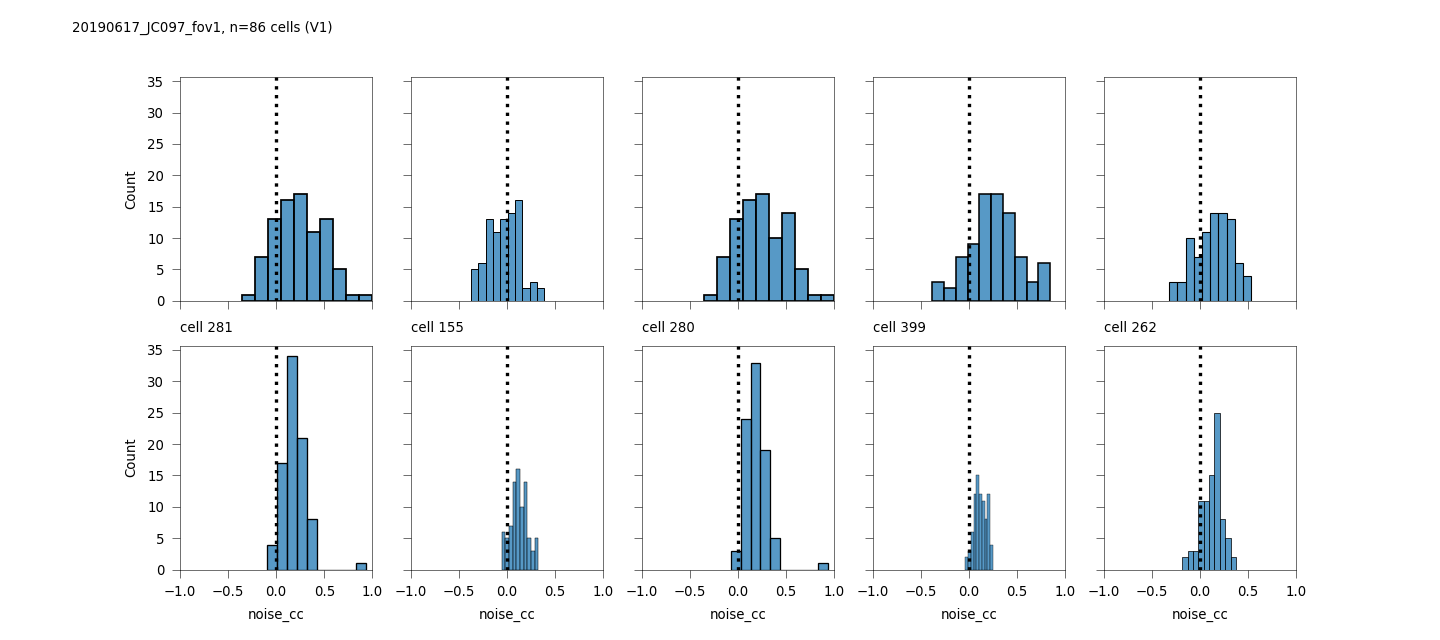

Text(0.05, 0.95, '20190617_JC097_fov1, n=86 cells (V1)')

In [127]:
rid=155
fig, axn = pl.subplots(2, 5, figsize=(9,4), sharex=True, sharey=True)

for ai, ri, in enumerate(top5):
    ax=axn[0, ai]
    currd = corrs[
                (corrs['cell_1']==ri) | (corrs['cell_2']==ri)].copy()
    sns.histplot(x='signal_cc', data=currd, ax=ax, bins=10)
    ax=axn[1, ai]
    sns.histplot(x='noise_cc', data=currd, ax=ax, bins=10)
    ax.set_title('cell %i' % ri, loc='left', fontsize=6)
    
for ax in axn.flat:
    ax.set_xlim([-1, 1])
    ax.axvline(x=0, color='k', ls=':')
    
fig.text(0.05, 0.95, '%s, n=%i cells (%s)' % (dk, len(rois_), va))

#### Scatter plot comparing Signal/Noise per cell

In [128]:
nplot=20
top_ = currfits.sort_values(by=sorter, ascending=False)\
        [['gof', 'r2', 'response_pref', 'tf', 'cell']].iloc[0:nplot]['cell'].values

In [129]:
currfits.head()

,asi,dsi,response_null,response_offset,response_pref,sigma,theta_pref,r2,cell,r2comb,...,sf,size,speed,visual_area,datakey,animalid,fov,session,tf,tested_theta
2775,0.195308,0.571425,0.020930,-0.021574,0.090963,74.579649,191.020408,0.853096,1.0,0.760906,...,0.1,200.0,20.0,V1,20190617_JC097_fov1,JC097,FOV1_zoom2p0x,20190617,2.0,180.0
2782,0.496438,0.252988,0.082878,-0.039848,0.102565,54.962971,88.163265,0.796958,22.0,0.710106,...,0.5,20.0,10.0,V1,20190617_JC097_fov1,JC097,FOV1_zoom2p0x,20190617,5.0,90.0
2788,0.736206,0.119156,0.041650,0.007465,0.052532,22.501239,264.489796,0.897492,37.0,0.825375,...,0.1,200.0,10.0,V1,20190617_JC097_fov1,JC097,FOV1_zoom2p0x,20190617,1.0,270.0
2799,0.552736,0.607409,0.030281,-0.001267,0.081455,37.089249,279.183673,0.788202,52.0,0.698670,...,0.1,20.0,20.0,V1,20190617_JC097_fov1,JC097,FOV1_zoom2p0x,20190617,2.0,270.0
2804,0.213157,0.491717,0.019220,-0.023134,0.056257,86.467439,315.918367,0.774580,60.0,0.719698,...,0.5,20.0,20.0,V1,20190617_JC097_fov1,JC097,FOV1_zoom2p0x,20190617,10.0,315.0


In [279]:
importlib.reload(pplot)

<module 'utils.plotting' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/utils/plotting.py'>

In [131]:
sorted_={}
nplot=10
for d, g in currfits.groupby(['tested_theta']):
    sorted_[d] = g.sort_values(by=sorter, ascending=False)\
                                .iloc[0:nplot]['cell'].values
sorted_

{45.0: array([100.]),
 90.0: array([280., 399., 361., 229., 125., 211.,  66.,  22.]),
 135.0: array([155., 146., 119.]),
 180.0: array([203.,   1., 291.,  91.]),
 225.0: array([262., 123., 200.,  69., 377., 111.,  65.]),
 270.0: array([281., 311.,  37., 215., 104., 216.,  52., 224., 107.]),
 315.0: array([183.,  60.])}

<IPython.core.display.Javascript object>


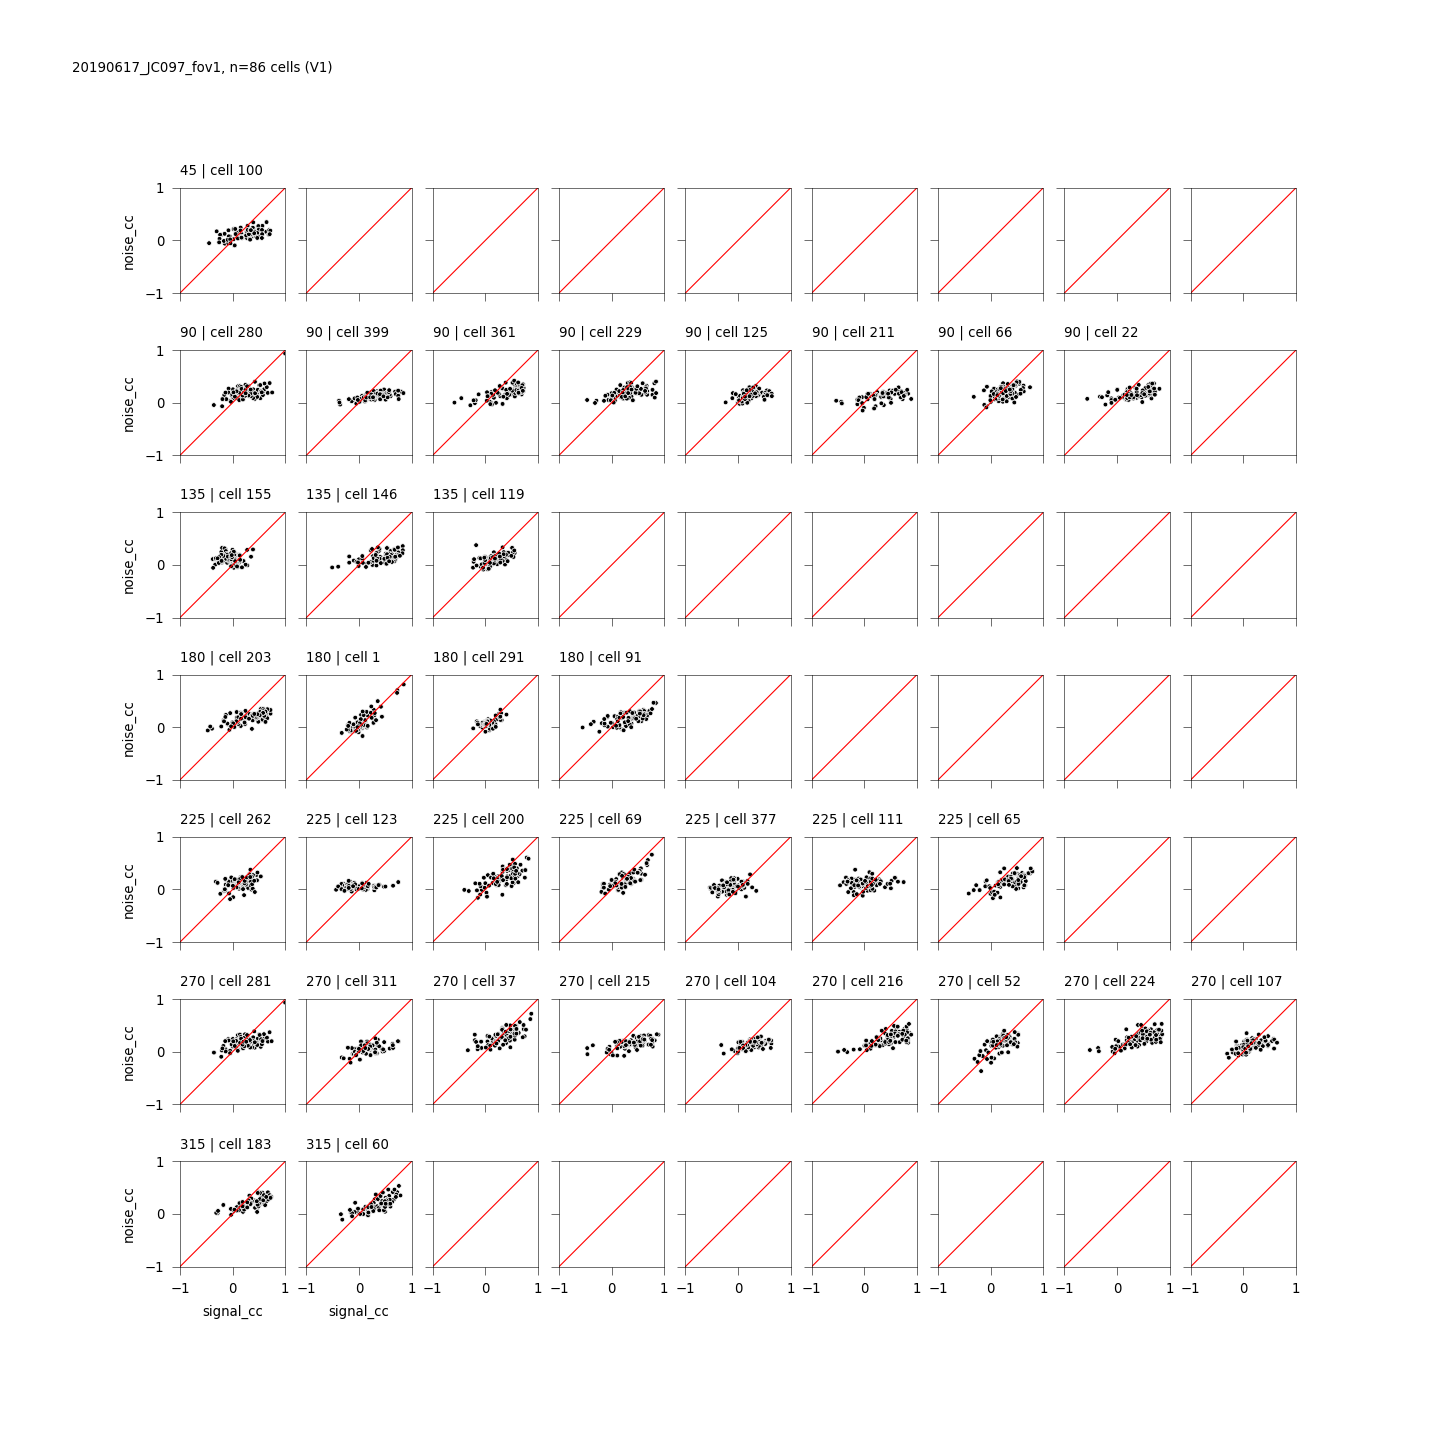

Text(0.05, 0.95, '20190617_JC097_fov1, n=86 cells (V1)')

In [132]:
ncol=max([len(v) for k, v in sorted_.items()])

fig, axn = pl.subplots(len(sorted_), ncol, figsize=(9,9), sharex=True, sharey=True)
for ai, (k, v) in enumerate(sorted_.items()):
    for ci, ri in enumerate(v):
        ax=axn[ai, ci]
        currd = corrs[(corrs['cell_1']==ri) | (corrs['cell_2']==ri)].copy()
        sns.scatterplot(x='signal_cc', y='noise_cc', data=currd, ax=ax,
                   size=1, color='k', marker='.')
        ax.set_title('%i | cell %i' % (k, ri), loc='left', fontsize=6)
        ax.legend_.remove()
pplot.equal_corr_axes(fig)

fig.text(0.05, 0.95, '%s, n=%i cells (%s)' % (dk, len(rois_), va))

# Receptive field position?

In [241]:
# Load RF data
do_spherical_correction=False
# Get cells and metadata
assigned_cells, rf_meta = aggr.select_assigned_cells(cells0, sdata, 
                                                experiments=['rfs', 'rfs10']) 
# Load RF fit data
rf_fit_desc = rfutils.get_fit_desc(response_type=response_type, 
                                 do_spherical_correction=do_spherical_correction)
rfdata = rfutils.aggregate_rfdata(rf_meta, assigned_cells, fit_desc=rf_fit_desc,
                                 reliable_only=False)
# Combined rfs5/rfs10
combined_rfs = rfutils.average_rfs_select(rfdata)

N dpaths: 62, N unfit: 0
N datasets included: 62, N sessions excluded: 4


In [252]:
# Get ROI positions
rfdf = aggr.add_rf_positions(rfdata)
rf_dkeys = [(va, dk) for (va, dk), g in rf_meta.groupby(['visual_area', 'datakey'])]
rfCELLS = pd.concat([g for (va, dk), g in \
                     assigned_cells.groupby(['visual_area', 'datakey'])\
                    if (va, dk) in rf_dkeys])

Adding RF position info...


#### Combine GDATA and RFDATA

In [254]:
RFS=[]
GFS=[]
for (va, dk), gr_ in bestg.groupby(['visual_area', 'datakey']):
    rfs_ = rfdf[(rfdf['visual_area']==va) 
                      & (rfdf['datakey']==dk)].copy()
    if len(rfs_)==0:
        continue
    rf_cells = rfs_['cell'].unique()
    gr_cells = gr_['cell'].unique()
    common_cells = np.intersect1d(rf_cells, gr_cells)
    print('%s: %i cells in common (%s)' % (va, len(common_cells), dk))
    RFS.append(rfs_[rfs_['cell'].isin(common_cells)])
    GFS.append(gr_[gr_['cell'].isin(common_cells)])
    
RFS = pd.concat(RFS, axis=0).reset_index(drop=True)
GFS = pd.concat(GFS, axis=0).reset_index(drop=True)
print(GFS.shape, RFS.shape)
cols_to_use = RFS.columns.difference(GFS.columns)
DF = pd.merge(GFS, RFS[cols_to_use], left_index=True, right_index=True, how='outer')
print(DF['theta'].min(), DF['theta'].max())
DF['theta_deg'] = np.rad2deg(DF['theta_Mm_c'])
print(DF['theta_deg'].min(), DF['theta_deg'].max())
DF.dropna().groupby(['visual_area']).count()

Li: 2 cells in common (20190522_JC089_fov1)
Li: 5 cells in common (20190527_JC092_fov3)
Li: 40 cells in common (20190602_JC091_fov1)
Li: 6 cells in common (20190606_JC091_fov1)
Li: 10 cells in common (20190607_JC091_fov1)
Li: 1 cells in common (20190609_JC099_fov1)
Li: 3 cells in common (20190612_JC099_fov1)
Li: 14 cells in common (20190614_JC091_fov1)
Li: 1 cells in common (20190617_JC099_fov1)
Li: 5 cells in common (20191018_JC113_fov1)
Li: 0 cells in common (20191105_JC117_fov1)
Li: 0 cells in common (20191111_JC120_fov1)
Lm: 27 cells in common (20190512_JC083_fov1)
Lm: 19 cells in common (20190513_JC078_fov1)
Lm: 4 cells in common (20190517_JC083_fov1)
Lm: 25 cells in common (20190525_JC084_fov1)
Lm: 29 cells in common (20190603_JC080_fov1)
Lm: 6 cells in common (20190618_JC097_fov1)
Lm: 5 cells in common (20190627_JC091_fov1)
V1: 43 cells in common (20190511_JC083_fov1)
V1: 5 cells in common (20190512_JC083_fov1)
V1: 1 cells in common (20190517_JC083_fov1)
V1: 81 cells in common (

,asi,dsi,response_null,response_offset,response_pref,sigma,theta_pref,r2,cell,r2comb,...,std_avg,std_x,std_y,theta,theta_Mm_c,theta_Mm_deg,theta_c,x0,y0,theta_deg
visual_area,,,,,,,,,,,,,,,,,,,,,
Li,87,87,87,87,87,87,87,87,87,87,...,87,87,87,87,87,87,87,87,87,87
Lm,115,115,115,115,115,115,115,115,115,115,...,115,115,115,115,115,115,115,115,115,115
V1,382,382,382,382,382,382,382,382,382,382,...,382,382,382,382,382,382,382,382,382,382


In [255]:
%matplotlib notebook

<IPython.core.display.Javascript object>


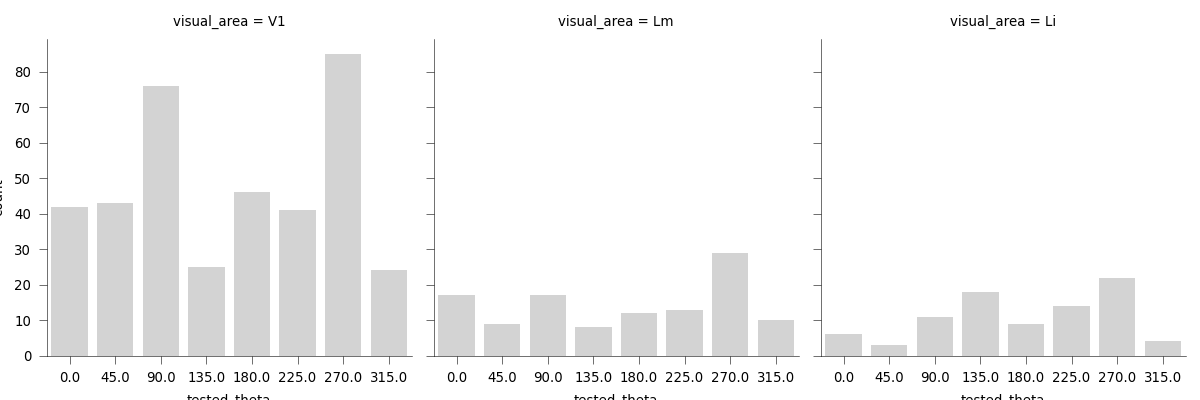

In [256]:
sns.catplot(x='tested_theta', col='visual_area', data=DF, kind='count',
            height=2.5, col_order=visual_areas, color='lightgrey')

In [257]:
# va='V1'
# dk='20190617_JC097_fov1'
# df_ = DF[(DF.visual_area==va) & (DF.datakey==dk)].copy()
# df_.shape

In [258]:
DF['mod_theta'] = DF['tested_theta'] % 180.
DF['mod_theta'].min(), DF['mod_theta'].max()

(0.0, 135.0)

[  0.  45.  90. 135.]


<IPython.core.display.Javascript object>


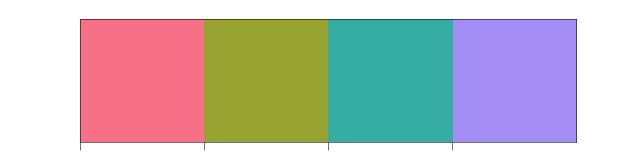

In [259]:
#colormap = 'batlow' #'nic_Edge'
#dark_cmap = pplot.darken_cmap(colormap)
color_ori=True
n_colors = 4 if color_ori else 8
color_vals = np.linspace(0, 135, 4) if color_ori else np.linspace(0, 315, 8)
print(color_vals)
theta_cmap = sns.husl_palette(n_colors) #, l=1, h=1, s=0)
# Set colors
sns.palplot(theta_cmap)
theta_colors = dict((k, v) for k, v in zip(color_vals, theta_cmap))

In [260]:
theta_vals

array([  0.,  45.,  90., 135., 180., 225., 270., 315., 360.])

{0: 'r', 45: 'r', 315: 'r', 180: 'b', 135: 'b', 225: 'b'}


<IPython.core.display.Javascript object>


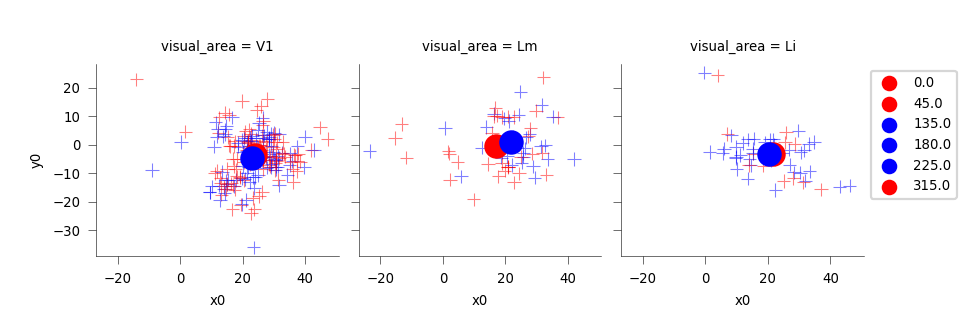

V1: nasal=(23.9, -3.6) | temporal (22.9, -4.7)
Lm: nasal=(17.0, -0.6) | temporal (21.7, 0.9)
Li: nasal=(21.7, -3.3) | temporal (20.2, -3.2)


In [284]:
# 0: Nasal, 180: Temporal
# 90: Upward, 270: Downward
nasal_color = 'r'
temporal_color='b'
nasal_ = [0, 45, 315]
temporal_ = [180, 135, 225]

theta_colors = dict((k, nasal_color) for k in nasal_)
theta_colors.update(dict((k, temporal_color) for k in temporal_))
print(theta_colors)

currdata = DF[(DF['dsi']>=0.1) & (DF['tested_theta'].isin(curr_oris))].copy()

curr_oris = theta_colors.keys() #[0, 180]
fg = sns.FacetGrid(col='visual_area', col_order=visual_areas, height=2,
                   data=currdata)
fg.map(sns.scatterplot, 'x0', 'y0', 'tested_theta', #palette=theta_colors,
      alpha=0.5, palette=theta_colors, marker='+', facecolor='none')
# sns.scatterplot(x='x0', y='y0', hue='tested_theta', data=df_, ax=ax,
#                palette=theta_colors)
pl.legend(loc='upper left', bbox_to_anchor=(1,1))
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8)

for ai, va in enumerate(visual_areas):
    ax = fg.axes.flat[ai]
    df_ = currdata[currdata.visual_area==va].copy()
    cx_n, cy_n = hutils.CoM(df_[df_['tested_theta'].isin(nasal_)][['x0', 'y0']])
    cx_t, cy_t = hutils.CoM(df_[df_['tested_theta'].isin(temporal_)][['x0', 'y0']])
    
    ax.plot(cx_n, cy_n, color=nasal_color, marker='o', markersize=10)
    ax.plot(cx_t, cy_t, color=temporal_color, marker='o', markersize=10)

    print('%s: nasal=(%.1f, %.1f) | temporal (%.1f, %.1f)' % (va, cx_n, cy_n, cx_t, cy_t))
    

In [282]:
%matplotlib notebook

# Spatial relationship?

In [273]:
importlib.reload(aggr)

<module 'utils.aggregate_datasets' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/utils/aggregate_datasets.py'>

In [351]:
NDATA['experiment'] = 'gratings'
posdf = NDATA[['visual_area', 'datakey', 'experiment', 'cell']].copy()\
        .drop_duplicates().reset_index(drop=True)
# Get ROI positions
posdf = aggr.add_roi_positions(posdf)

Adding ROI position info...


In [352]:
redo_pos = []
for (va, dk), g in posdf.groupby(['visual_area', 'datakey']):
    if len(g['ml_pos'].unique())==1:
        redo_pos.append(dk)
redo_pos

for dk in redo_pos:
    session, animalid, fovnum = hutils.split_datakey_str(dk)
    fovinfo = roiutils.load_roi_coords(animalid, session, 'FOV%i_zoom2p0x' % fovnum,
                                      traceid=traceid, create_new=True)

[]

In [275]:
# selective_only=False
# stimulus_type='allstim'

# assert stimulus_type in ['fullscreen', 'apertured', 'allstim']

# if stimulus_type=='fullscreen':
#     SD = fullSDF.copy()
# elif stimulus_type=='apertured':
#     SD = apSDF.copy()
# else:
#     SD = SDF.copy()
    
# roi_filter='gof%.2f' % gof_thr if selective_only else 'allcells'
# print(roi_filter)

In [471]:
min_ncells=5
selective_only=False
c_=[]
for (va, dk), ndf in NDATA.groupby(['visual_area', 'datakey']):
    # ndf = NDATA[(NDATA.visual_area==va) & (NDATA.datakey==dk)].copy()
    # Select cells
    if selective_only:
        curr_cells = passg[(passg.visual_area==va) 
                        & (passg.datakey==dk)]['cell'].unique()
    else:
        curr_cells = ndf['cell'].unique()
    if len(curr_cells)<min_ncells:
        continue
    # Select stimuli and trials
    sdf = aggr.get_stimuli(dk, experiment='gratings')
    curr_cfgs = sdf.index.tolist()
    cc_ = calculate_corrs(ndf, curr_cells=curr_cells, curr_cfgs=curr_cfgs)
    cc_['visual_area']=va
    cc_['datakey']=dk
    c_.append(cc_)
CC = pd.concat(c_, axis=0)


In [278]:
SDF={}
for (va, dk), g in NDATA.groupby(['visual_area', 'datakey']):
    sdf = p3.get_stimuli(dk, 'gratings')
    SDF[dk] = sdf

In [279]:
fullSDF = {}
for dk, sdf in SDF.items():
    subset = sdf[sdf['size']>50][['ori', 'sf', 'size', 'speed']].copy()
    if len(subset)==0:
        print(dk)
    fullSDF[dk] = subset #.append(subset)

In [280]:
apSDF={}
for dk, sdf in SDF.items():
    subset = sdf[sdf['size']<100][['ori', 'sf', 'size', 'speed']].copy()
    if len(subset)==0:
        print(dk)
    apSDF[dk] = subset #.append(subset)

20190522_JC089_fov1
20190527_JC092_fov3


In [472]:
c_ = []
for (va, dk), cc_ in CC.groupby(['visual_area', 'datakey']):
    # Get current FOV rfdata and add position info to sigcorrs df
    r1 = cc_['cell_1'].unique()
    r2 = cc_['cell_2'].unique()
    rois_ = np.union1d(r1, r2)
    pos_ = posdf[(posdf.visual_area==va) & (posdf.datakey==dk)].copy()
    assert len([r for r in rois_ if r not in pos_['cell'].values])==0, \
        "[%s, %s]: incorrect roi indexing in RFDATA" % (va, dk)
    pos_.index = pos_['cell'].values
    # Coords of cell1 in pair, in order
    coords1 = np.array(pos_.loc[cc_['cell_1'].values][['ml_pos', 'ap_pos']])
    # Coords of cell2 in pair 
    coords2 = np.array(pos_.loc[cc_['cell_2'].values][['ml_pos', 'ap_pos']])
    # Get dists, in order of appearance
    dists = [np.linalg.norm(c1-c2) for c1, c2 in zip(coords1, coords2)]
    cc_['cortical_distance'] = dists
    cc_['visual_area'] = va
    cc_['datakey'] = dk
    c_.append(cc_)
corrdist = pd.concat(c_, axis=0).reset_index(drop=True)


In [854]:
# Bin cortical distances for plotting
autosplit=False
if autosplit:
    n_bins_dist = 6
    use_quartile=False
    bin_type = 'eqpop%i' % n_bins_dist if use_quartile else 'eqwidth%i' % n_bins_dist
    print("binning: %s" % bin_type)
    if use_quartile:
        corrdist['binned_dist'], bin_edges = pd.qcut(corrdist['cortical_distance'], \
                                        n_bins_dist, labels=False, retbins=True)
    else:
        corrdist['binned_dist'], bin_edges = pd.cut(corrdist['cortical_distance'], \
                                         n_bins_dist,labels=False, retbins=True)
else:
    bin_type='custombins'
    corrdist['binned_dist'] = pd.cut(x=corrdist['cortical_distance'], 
                                bins=[0, 100, 300, 500, np.inf], 
                                labels=['<100', '100-300', '300-500', '>500'])

mean_ccs = corrdist.groupby(['visual_area', 'datakey', 'binned_dist'])\
                        .mean().reset_index()

<IPython.core.display.Javascript object>


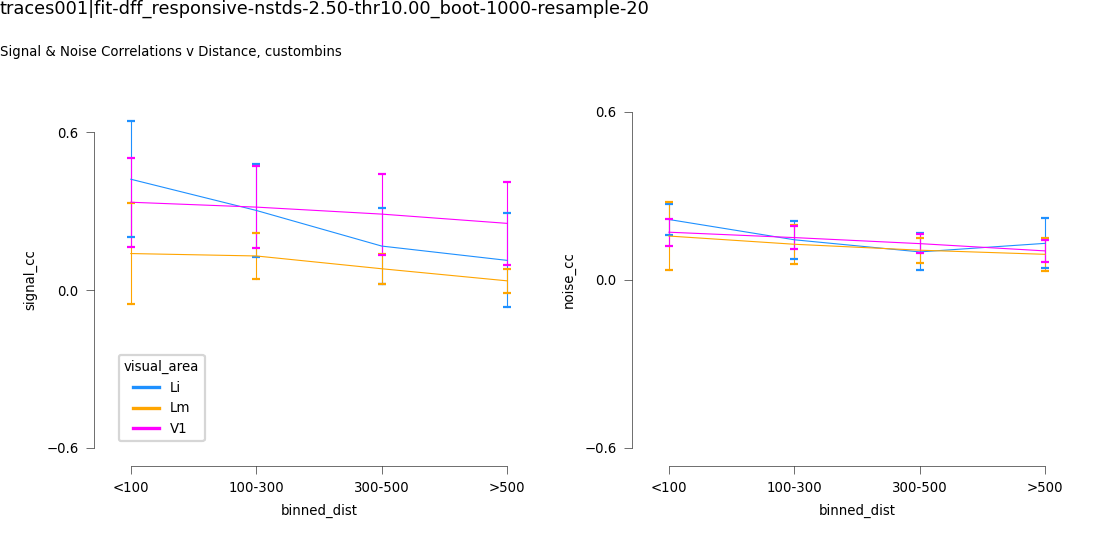

Text(0, 0.9, 'Signal & Noise Correlations v Distance, custombins')

In [855]:
lw=0.5

fig, axn = pl.subplots( 1, 2, figsize=(7,3.5)) #, sharex=True, sharey=False)
for ax, metric in zip(axn.flat, ['signal_cc', 'noise_cc']):
    sns.lineplot(x='binned_dist', y=metric, data=mean_ccs, ax=ax,
             hue='visual_area', palette=area_colors, ci='sd', err_style='bars', 
             err_kws={'capsize':2, 'lw': lw}, lw=lw)
    #ax.set_xticks(list(range(len(bin_edges))))
    #ax.set_xticklabels([round(i) for i in bin_edges])
    #ax.set_ylim([-0.7, 0.7])
    ax.set_yticks(np.linspace(-0.6, 0.6, 3)) #([-0.6, 0.6])
    sns.despine(offset=8, trim=True, ax=ax)
    
ax.legend_.remove()
pl.subplots_adjust(top=0.8, left=0.1, right=0.95, bottom=0.2, wspace=0.3, hspace=0.5)

pplot.label_figure(fig, data_id)
fig.text(0, 0.9, 'Signal & Noise Correlations v Distance, %s' % bin_type)
# figname = 'sigcorrs_by_dist__%s_%s' % (stimulus_type, roi_filter)
# pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
# print(curr_dst_dir, figname)

# Compare difference in preferred dirs

In [1420]:
c_ = []
for (va, dk), cc_ in corrdist.groupby(['visual_area', 'datakey']):
    # Get current FOV rfdata and add position info to sigcorrs df
    gfit_ =  passg[(passg.visual_area==va) & (passg.datakey==dk)
                  & (passg['asi']>=0.2)].copy()
    gfit_.index = gfit_['cell'].values
    rois_ =  gfit_['cell'].unique()
    if len(rois_)==0:
        continue
    tmpc = cc_[cc_['cell_1'].isin(rois_) & cc_['cell_2'].isin(rois_)].copy()
    diff_theta = gfit_.loc[tmpc['cell_1']]['theta_pref'].values \
                    - gfit_.loc[tmpc['cell_2']]['theta_pref'].values
    v = diff_theta % 360.
    thetas_range = ((v - 180) % 360) - 180 # -180, 180
    #to_deg = np.array([np.rad2deg(i) for i in thetas_range])
    #print(min(to_deg), max(to_deg))
#     thetas_range = [ (theta + 90) % 360 if (90 <= theta < 360) \
#         else (((theta) % 90) + 90) % 360 for theta in v]
#     thetas_range = np.array([(t % 180.) - 180. if ((90<t<180) or (270<t<360)) \
#                      else (t % 180.) for t in v ])
    #thetas_range2 = (v + 180) % 180. # (0, 180)
    tmpc['pref_theta_diff'] = thetas_range #% 360. #% 180.
    c_.append(tmpc)
fitdist = pd.concat(c_, axis=0).reset_index(drop=True)

fitdist['pref_theta_diff'].min(), fitdist['pref_theta_diff'].max() # Range from -180 to 180

(-176.32653061224494, 176.32653061224494)

In [1421]:
fitdist

,cell_1,cell_2,signal_cc,neuron_pair,noise_cc,visual_area,datakey,cortical_distance,binned_dist,pref_theta_diff
0,172,187,-0.478374,172_187,0.044495,Li,20190314_JC070_fov1,217.661674,100-300,95.510204
1,172,216,0.727695,172_216,0.246881,Li,20190314_JC070_fov1,451.735098,300-500,-7.346939
2,172,220,0.783481,172_220,-0.004236,Li,20190314_JC070_fov1,456.918526,300-500,-7.346939
3,172,235,0.099065,172_235,-0.005421,Li,20190314_JC070_fov1,662.784857,>500,124.897959
4,172,253,0.135893,172_253,0.067974,Li,20190314_JC070_fov1,468.471708,300-500,-58.775510
...,...,...,...,...,...,...,...,...,...,...
18042,237,266,0.460840,237_266,0.240423,V1,20191006_JC110_fov1,172.559270,100-300,-161.632653
18043,237,313,0.504684,237_313,0.081655,V1,20191006_JC110_fov1,359.807776,300-500,51.428571
18044,245,266,0.708482,245_266,0.408278,V1,20191006_JC110_fov1,96.025434,<100,-168.979592
18045,245,313,0.457018,245_313,0.116141,V1,20191006_JC110_fov1,443.795066,300-500,44.081633


In [1422]:
# # Bin cortical distances for plotting
# -----------------------------------------------
# n_bins_dist = 5
# use_quartile=False
# bin_type = 'eqpop%i' % n_bins_dist if use_quartile else 'eqwidth%i' % n_bins_dist
# print("binning: %s" % bin_type)
# if use_quartile:
#     fitdist['binned_dist'], bin_edges = pd.qcut(fitdist['cortical_distance'], \
#                                     n_bins_dist, labels=False, retbins=True)
# else:
#     fitdist['binned_dist'], bin_edges = pd.cut(fitdist['cortical_distance'], \
#                                      n_bins_dist,labels=False, retbins=True)

#fitdist['binned_dist'] = None
# bins_ = [0, 100, 200, 300, 400, 500, np.inf]
# dist_labels = ['<100', '100-200', '200-300', '300-400', '400-500', '>500']

bins_ = [0, 150, 300, 450, np.inf]
dist_labels=[]
for i, b in enumerate(bins_[0:-1]):
    if i==0:
        dist_labels.append('<%i' % bins_[i+1])
    elif i==len(bins_)-2:
        dist_labels.append('>%i' % bins_[-2])
    else:
        dist_labels.append('%i-%i' % (b, bins_[i+1]))
# dist_labels = ['<100', '100-300', '300-500', '>500']
print(dist_labels)
fitdist['binned_dist'] = pd.cut(x=fitdist['cortical_distance'], 
                                bins=bins_,labels=dist_labels)


['<150', '150-300', '300-450', '>450']


In [1434]:
# bin thetas
# -----------------------------------------------
#metric='abs_diff'
metric = 'pref_theta_diff'
if metric=='abs_diff':
    fitdist['abs_diff'] = np.abs(fitdist['pref_theta_diff'])
    bins_ = np.linspace(0, 180, 6)
    theta_labels = np.linspace(0, 180, 6)[0:-1]
    fitdist['binned_theta'] = pd.cut(x=fitdist['abs_diff'],
                                     bins=bins_, labels=theta_labels)
else:
    bins_ = [-np.inf]
    vmin=-180; vmax=180;
    n_steps = 10
    int_size = np.mean(np.diff(np.linspace(vmin, vmax, n_steps)))

    rg = np.linspace(vmin, vmax, n_steps) + int_size/2.
    bins_.extend(rg[0:-1])
    bins_.append(np.inf)
    theta_labels = np.linspace(vmin, vmax, n_steps)
    fitdist['binned_theta'] = pd.cut(x=fitdist['pref_theta_diff'],
                                     bins=bins_, labels=theta_labels)
print(bins_)
print(theta_labels)

[-inf, -160.0, -120.0, -80.0, -40.0, 0.0, 40.0, 80.0, 120.0, 160.0, inf]
[-180. -140. -100.  -60.  -20.   20.   60.  100.  140.  180.]


<IPython.core.display.Javascript object>


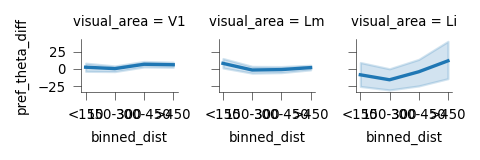

In [1435]:
fg = sns.FacetGrid(col='visual_area', col_order=visual_areas, data=fitdist, height=1)
fg.map(sns.lineplot, 'binned_dist', metric)

In [1436]:
# fitdist['abs_diff_rad'] = [np.deg2rad(i) for i in fitdist['abs_diff'].values]

# fitdist['binned_rad'] = [np.deg2rad(i) for i in fitdist['binned_theta'].values]

# print(fitdist['abs_diff_rad'].min(), fitdist['abs_diff_rad'].max())
# print(fitdist['binned_rad'].min(), fitdist['binned_rad'].max())
# fitdist.head()

In [1437]:
# Mean by FOV
mean_fitdist = fitdist.groupby(
                ['visual_area', 'datakey', 'binned_dist', 'binned_theta'])\
                .mean().reset_index().dropna()
mean_fitdist.head()
# cols = ['visual_area', 'datakey', 'binned_dist', 'binned_rad', 'abs_diff_rad']
# groups = ['visual_area', 'datakey', 'binned_dist', 'binned_rad']
# mean_fitdist = fitdist[cols].groupby(groups)\
#                         .apply(spstats.circmean, 
#                         high=np.pi, low=0, nan_policy='omit').reset_index()\
#                         .rename(columns={0: 'abs_diff_rad'})
# mean_fitdist['abs_diff'] = [np.rad2deg(i) for \
#                                     i in mean_fitdist['abs_diff_rad'].values]
# mean_fitdist['binned_theta'] = [np.rad2deg(i) for \
#                                     i in mean_fitdist['binned_rad'].values]

,visual_area,datakey,binned_dist,binned_theta,cell_1,cell_2,signal_cc,noise_cc,cortical_distance,pref_theta_diff,abs_diff
40,Li,20190314_JC070_fov1,<150,-180.0,297.0,318.0,0.050655,0.433490,107.332928,-176.326531,176.326531
41,Li,20190314_JC070_fov1,<150,-140.0,279.0,297.0,-0.149087,-0.083493,107.157176,-154.285714,154.285714
43,Li,20190314_JC070_fov1,<150,-60.0,218.0,253.0,0.293214,0.181292,101.372948,-51.428571,51.428571
44,Li,20190314_JC070_fov1,<150,-20.0,254.0,270.5,0.541135,0.144238,93.358755,-18.367347,18.367347
51,Li,20190314_JC070_fov1,150-300,-140.0,211.0,259.5,-0.128815,0.023185,271.443274,-154.285714,154.285714


In [1438]:
# d_=[]
# for (va, dk, b_dist, b_theta), g in fitdist.groupby(
#         ['visual_area', 'datakey', 'binned_dist', 'binned_theta']):
#     cells_in_bin = np.union1d(g['cell_1'].unique(), g['cell_2'].unique())
#     df_ = pd.DataFrame({'cell': cells_in_bin})
#     df_['visual_area'] = va
#     df_['datakey'] = dk
#     df_['binned_dist'] = b_dist
#     df_['binned_theta'] = b_theta
#     d_.append(df_)
# cells_in_bin = pd.concat(d_)

In [1439]:
# meanfit = fitdist.groupby(
#             ['visual_area', 'datakey', 'binned_dist'])['abs_diff']\
#             .mean().dropna().reset_index()
# meanfit.groupby(['visual_area', 'binned_dist']).mean()

<IPython.core.display.Javascript object>


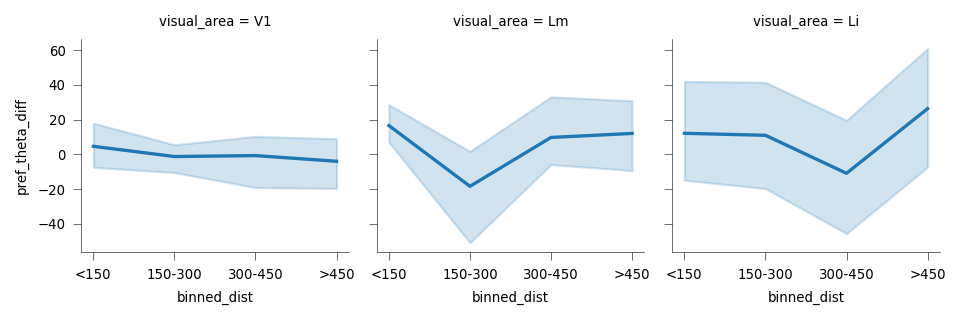

In [1440]:
meanfit = fitdist.groupby(
            ['visual_area', 'datakey', 'binned_dist'])[metric]\
            .mean().dropna().reset_index()
fg = sns.FacetGrid(col='visual_area', col_order=visual_areas, data=meanfit, height=2)
fg.map(sns.lineplot, 'binned_dist', metric)

In [1441]:
counts = fitdist.groupby(['visual_area', 'binned_dist', 'binned_theta'])\
            ['neuron_pair'].count().reset_index()\
        .rename(columns={'neuron_pair': 'n_theta_bin'})
counts
counts['n_dist_bin'] = None
for (va, bd), g in counts.groupby(['visual_area', 'binned_dist']):
    counts.loc[g.index, 'n_dist_bin'] = g['n_theta_bin'].sum()
counts['fraction'] = counts['n_theta_bin'] / counts['n_dist_bin'].astype(float)

<IPython.core.display.Javascript object>


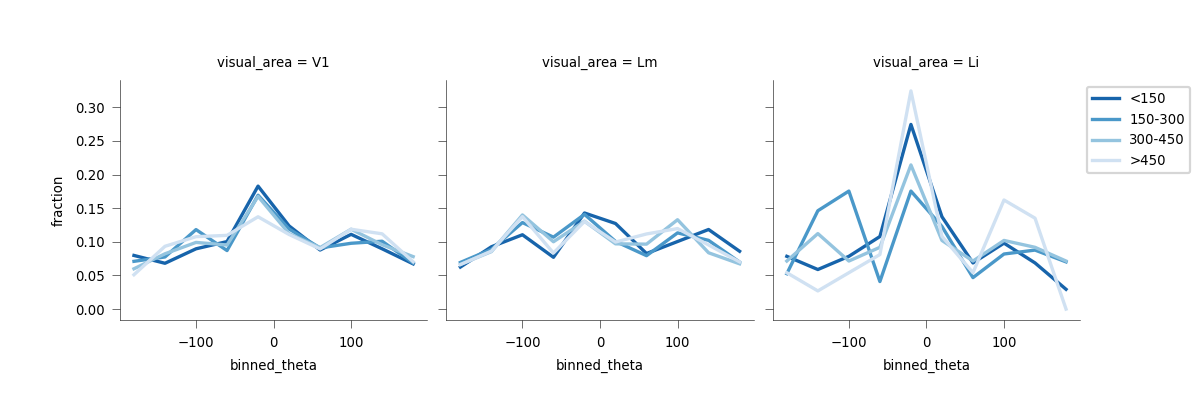

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m i

In [1442]:
dist_c = sns.color_palette('Blues_r', n_colors=len(dist_labels))
dist_colors = dict((k, v) for k, v in zip(dist_labels, dist_c))

#{'<150': 'b', '150-300': 'g', '300-450': 'r', '>450': 'k'}
plotd = counts.copy() #[counts['binned_dist']!='>450']
fg = sns.FacetGrid(col='visual_area', col_order=visual_areas, data=plotd,
                  height=2.5)
fg.map(sns.lineplot, 'binned_theta', 'fraction', 'binned_dist',
      palette=dist_colors)

pl.legend(loc='upper left', bbox_to_anchor=(1,1))
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8)

<IPython.core.display.Javascript object>


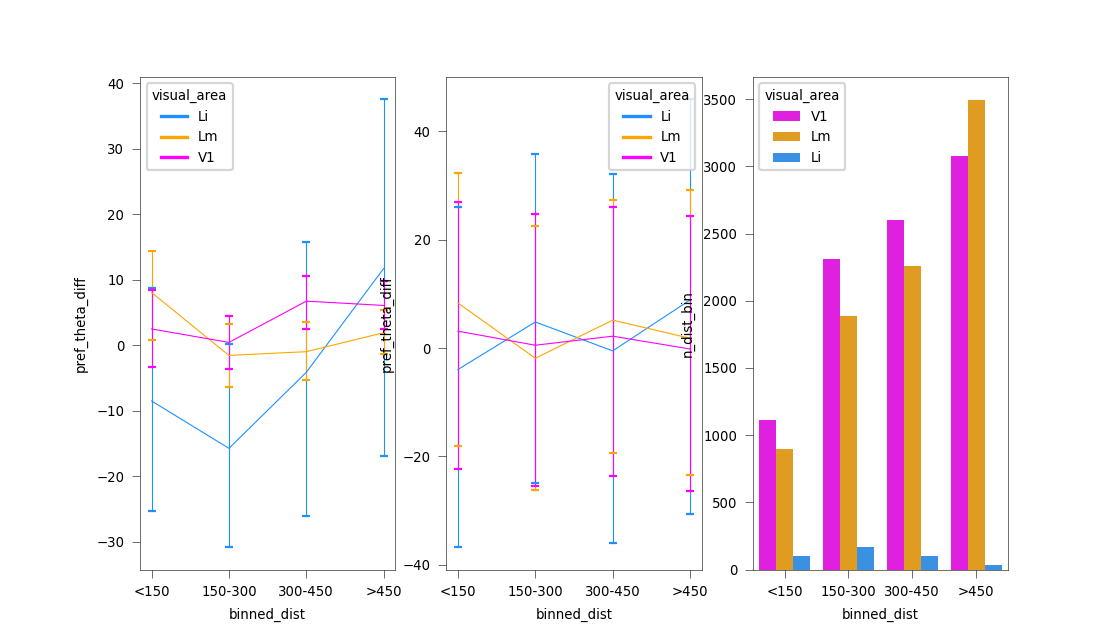

<AxesSubplot:xlabel='binned_dist', ylabel='n_dist_bin'>

In [1443]:
lw=0.5

fig, axn = pl.subplots(1,3,figsize=(7,4)) #, sharex=True, sharey=False)
# metric='abs_diff'
# metric = 'pref_deg_diff'
ax=axn[0]
sns.lineplot(x='binned_dist', y=metric, data=fitdist, ax=ax,
             hue='visual_area', palette=area_colors, ci=95,
             err_style='bars', 
             err_kws={'capsize':2, 'lw': lw}, lw=lw)

ax=axn[1]
sns.lineplot(x='binned_dist', y=metric, data=mean_fitdist, ax=ax,
             hue='visual_area', palette=area_colors, ci=95,
             err_style='bars', 
             err_kws={'capsize':2, 'lw': lw}, lw=lw)

ax=axn[2]
plotd = counts[['visual_area', 'binned_dist', 'n_dist_bin']].drop_duplicates()
sns.barplot(x='binned_dist', y='n_dist_bin', data=plotd, ax=ax,
           hue='visual_area', palette=area_colors, hue_order=visual_areas)